# SignalDigger

## 介绍
SignalDigger是digger模块中的一个核心类，使用SigalDigger可以分析股票单因子各项表现

*** 步骤 ***
1. 实例化SignalDigger-指定因子绩效表现的输出路径和输出格式
2. 因子数据预处理-通常跟dataview结合使用
2. 进行因子研究和分析

# step 1 实例化SignalDigger-指定因子绩效表现的输出路径和输出格式

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
from jaqs_fxdayu.research import SignalDigger

# step 1：实例化SignalDigger 通过output_folder和output_format指定因子绩效表现的输出路径和输出格式，通过signal_name指定绩效文件名称
sd = SignalDigger(output_folder=".", output_format='pdf', signal_name="signal")

# step 2 因子数据预处理

## process_signal_before_analysis

- ` jaqs_fxdayu.research.signaldigger.digger.SignalDigger.process_signal_before_analysis(*args, **kwargs) `

**简要描述：**

- 将因子数据处理成signal_data--包含了因子及相关收益、quantile分组、涨跌空间等评价维度的综合数据(pandas.MultiIndex)

**参数：**


|参数名|必选|类型|说明|
|:----    |:---|:----- |-----   |
|signal|是  |pandas.DataFrame|因子值,日期为索引，股票品种为columns|
|price |是，price与daily_ret二选一  |pandas.DataFrame|因子涉及到的股票的价格数据，用于作为进出场价用于计算收益,日期为索引，股票品种为columns|
|daily_ret |是，price与daily_ret二选一  |pandas.DataFrame| 因子涉及到的股票的每日收益，日期为索引，股票品种为columns|
|benchmark_price | 否，benchmark_price与daily_benchmark_ret二选一  |pandas.DataFrame or pandas.Series|基准价格，日期为索引。用于计算因子涉及到的股票的持有期**相对收益**--相对基准。默认为空，为空时计算的收益为**绝对收益**。|
|daily_benchmark_ret | 否，benchmark_price与daily_benchmark_ret二选一  |pandas.DataFrame or pandas.Series|基准日收益，日期为索引。用于计算因子涉及到的股票的持有期**相对收益**--相对基准。默认为空，为空时计算的收益为**绝对收益**。|
|high |否  |pandas.DataFrame|因子涉及到的股票的最高价数据,用于计算持有期潜在最大上涨收益,日期为索引，股票品种为columns,默认为空|
|low |否  |pandas.DataFrame|因子涉及到的股票的最低价数据,用于计算持有期潜在最大下跌收益,日期为索引，股票品种为columns,默认为空|
|group |否  |pandas.DataFrame|因子涉及到的股票的分组(行业分类),日期为索引，股票品种为columns,默认为空。**注：当group不为空时，quantile计算会在group内进行，即在每个组别下进行排序划分quantile** |
|period |否  |int|持有周期,默认为5,即持有5天|
|n_quantiles |否  |int|根据每日因子值的大小分成n_quantiles组,默认为5,即将因子每天分成5组。**注：当group不为空时，quantile计算会在group内进行，即在每个组别下进行排序划分quantile**|
|mask |否  |pandas.DataFrame|一张由bool值组成的表格,日期为索引，股票品种为columns，表示在做因子分析时是否要对某期的某个品种过滤。对应位置为True则**过滤**（剔除）——不纳入因子分析考虑。默认为空，不执行过滤操作|
|can_enter |否  |pandas.DataFrame|一张由bool值组成的表格,日期为索引，股票品种为columns，表示某期的某个品种是否可以买入(进场)。对应位置为True则可以买入。默认为空，任何时间任何品种均可买入|
|can_exit |否  |pandas.DataFrame|一张由bool值组成的表格,日期为索引，股票品种为columns，表示某期的某个品种是否可以卖出(出场)。对应位置为True则可以卖出。默认为空，任何时间任何品种均可卖出|
|forward |否  |bool|收益对齐方式,forward=True则在当期因子下对齐下一期实现的收益；forward=False则在当期实现收益下对齐上一期的因子值。默认为True|
|commission |否 |float|手续费比例,每次换仓收取的手续费百分比,默认为万分之八0.0008|


**示例：**

In [11]:
import numpy as np
from jaqs_fxdayu.data import DataView

# 加载dataview数据集
dv = DataView()
dataview_folder = './data'
dv.load_dataview(dataview_folder)

# 定义信号过滤条件-非指数成分
df_index_member = dv.get_ts('index_member')
mask = dv.get_ts('index_member') == 0  # 定义信号过滤条件-非指数成分

# 定义可买入卖出条件——未停牌、未涨跌停
trade_status = dv.get_ts('trade_status')
can_trade = trade_status==1 # 可以交易
# 涨停
up_limit = dv.add_formula('up_limit', '(open - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False)
# 跌停
down_limit = dv.add_formula('down_limit', '(open - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False)
can_enter = np.logical_and(up_limit < 1, can_trade)  # 未涨停未停牌
can_exit = np.logical_and(down_limit < 1, can_trade)  # 未跌停未停牌

Dataview loaded successfully.


In [18]:
sd.process_signal_before_analysis(signal=dv.get_ts("pe"),
                                  price=dv.get_ts("close_adj"),
                                  high=dv.get_ts("high_adj"),
                                  low=dv.get_ts("low_adj"),
                                  group=dv.get_ts("sw1"),
                                  n_quantiles=5,
                                  mask=mask,
                                  can_enter=can_enter,
                                  can_exit=can_exit,
                                  period=5,
                                  benchmark_price=dv.data_benchmark,
                                  forward=True,
                                  commission=0.0008
                                   )

Nan Data Count (should be zero) : 0;  Percentage of effective data: 85%


# step 3 进行因子研究和分析

## signal_data

- ` jaqs_fxdayu.research.signaldigger.digger.SignalDigger.signal_data `

**简要描述：**

- process_signal_before_analysis方法处理后的signal_data--包含了因子及相关收益、quantile分组、涨跌空间等评价维度的综合数据(pandas.MultiIndex)
- 需要执行process_signal_before_analysis后该属性才有值

**返回：**

trade_date+symbol为MultiIndex,columns为signal(因子)、return(持有期相对/绝对收益)、upside_ret(持有期潜在最大上涨收益)、downside_ret(持有期潜在最大下跌收益)、group(分组/行业分类)、quantile(按因子值分组)

**示例：**

In [19]:
sd.signal_data.head()

signal    return  upside_ret  downside_ret group  \
trade_date symbol                                                         
20170503   000001.SZ   6.7925 -0.005637   -0.003045     -0.042326    银行   
           000002.SZ  10.0821  0.011225    0.016697     -0.029432   房地产   
           000008.SZ  42.9544 -0.049408    0.000463     -0.092972  机械设备   
           000009.SZ  79.4778 -0.069822    0.009714     -0.095426    综合   
           000027.SZ  20.4542 -0.019517    0.009404     -0.041616  公用事业   

                      quantile  
trade_date symbol               
20170503   000001.SZ         1  
           000002.SZ         1  
           000008.SZ         4  
           000009.SZ         5  
           000027.SZ         2

## benchmark_ret

- ` jaqs_fxdayu.research.signaldigger.digger.SignalDigger.benchmark_ret `

**简要描述：**

- 基准收益
- 需要执行process_signal_before_analysis且传入了benchmark_price后该属性才有值

**示例：**

In [6]:
sd.benchmark_ret.tail()

,close
trade_date,
20170925,-0.006597
20170926,-0.002958
20170927,-0.005527
20170928,-0.003981
20170929,-0.000320


## ret

- ` jaqs_fxdayu.research.signaldigger.digger.SignalDigger.ret `

**简要描述：**

- 因子相关股票池的收益信息
- 需要执行process_signal_before_analysis且传入了benchmark_price后该属性才有值

**返回：**

由股票池各股票的return、upside_ret、downside_ret所组成的字典(dict)

**示例：**

In [7]:
print(sd.ret.keys())
sd.ret["return"].head()

dict_keys(['return', 'upside_ret', 'downside_ret'])


symbol,000001.SZ,000002.SZ,000008.SZ,000009.SZ,000027.SZ,000039.SZ,000060.SZ,000061.SZ,000063.SZ,000069.SZ,...,601988.SH,601989.SH,601992.SH,601997.SH,601998.SH,603000.SH,603160.SH,603858.SH,603885.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
20170502,-0.012748,-0.009400,-0.060645,-0.042922,-0.015162,-0.032807,0.005199,0.000423,-0.006402,-0.011290,...,0.023618,-0.049392,-0.113737,0.001664,0.007408,-0.016581,0.013146,-0.019445,-0.012823,-0.022670
20170503,-0.005637,0.011225,-0.049408,-0.069822,-0.019517,-0.057451,-0.017162,-0.013408,-0.035379,0.005009,...,0.035464,-0.061670,-0.116677,0.025755,0.017915,-0.040529,-0.037061,-0.045260,-0.031050,-0.052526
20170504,0.008647,0.024790,-0.045152,-0.080454,-0.047912,-0.047729,-0.012925,-0.045922,-0.016502,0.000723,...,0.038719,-0.050292,-0.126928,0.029239,0.030259,-0.050401,-0.031111,-0.062009,-0.055990,-0.030355
20170505,0.029650,0.025362,-0.026835,-0.070643,-0.053107,-0.004268,-0.027992,-0.053341,-0.022091,0.017399,...,0.035087,-0.052918,-0.122614,0.062180,0.049734,-0.048412,-0.018459,-0.070290,-0.086487,-0.036765
20170508,0.021017,0.034281,-0.005983,-0.055006,-0.039849,-0.007500,-0.039059,-0.067527,0.011253,0.028046,...,0.012388,-0.043975,-0.049807,0.065397,0.021249,-0.051913,-0.048080,-0.054598,-0.077470,-0.038463


## create_information_report

- ` jaqs_fxdayu.research.signaldigger.digger.create_information_report() `

**简要描述：**

- ic分析
- 需要执行process_signal_before_analysis后才能执行该方法

**返回：**

ic分析结果，并将结果保存至预设目录

**示例：**

Information Analysis
                ic
IC Mean     -0.022
IC Std.      0.228
t-stat(IC)  -0.978
p-value(IC)  0.331
IC Skew      0.052
IC Kurtosis -1.054
Ann. IR     -0.097
Figure saved: /home/xinger/Desktop/jaqs_plus/jaqs-fxdayu/docs/_source/information_report.pdf


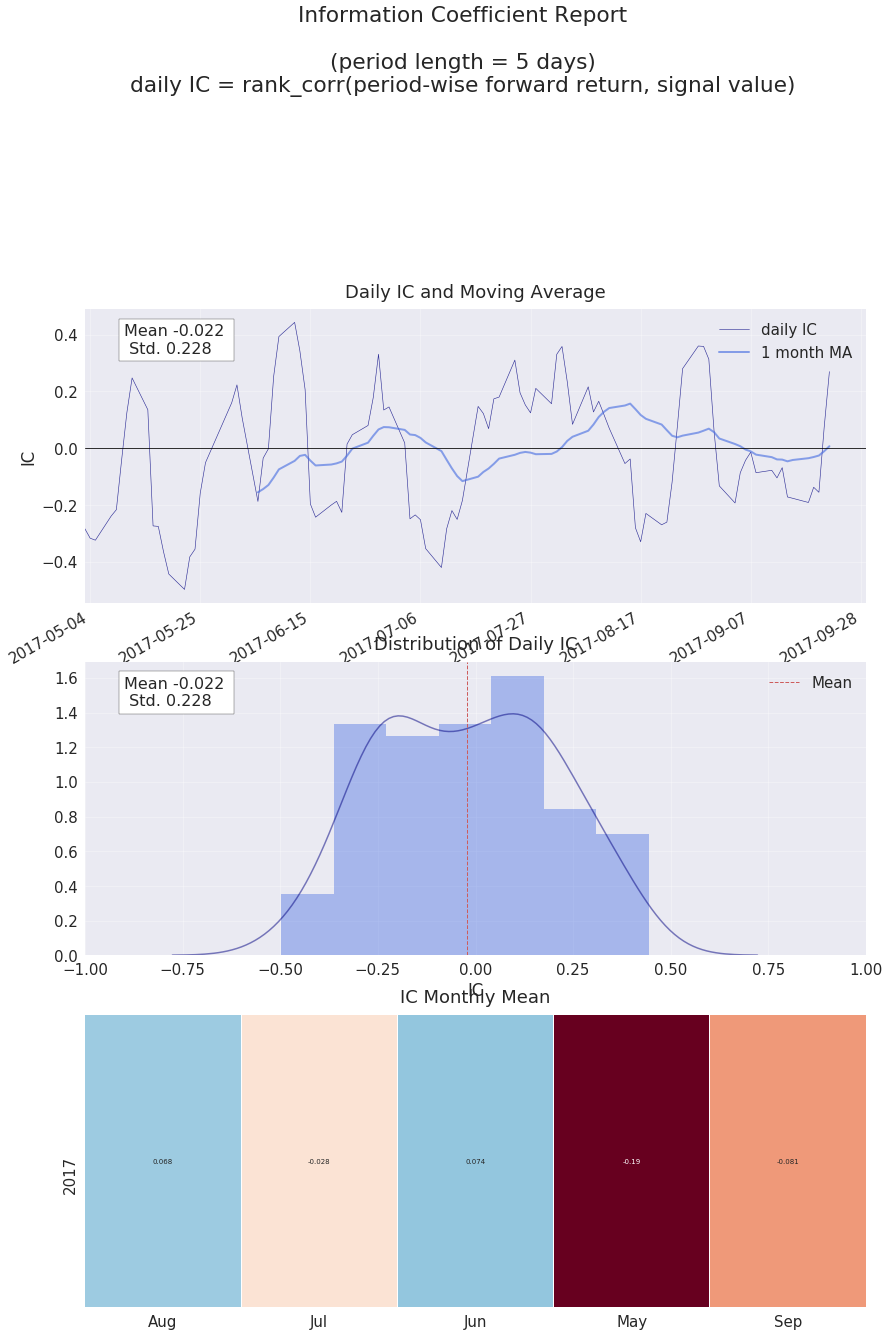

In [8]:
%matplotlib inline
sd.create_information_report()

## ic_report_data

- ` jaqs_fxdayu.research.signaldigger.digger.ic_report_data `

**简要描述：**

- ic分析相关数据
- 需要执行create_information_report后该属性才有值

**返回：**

由'daily_ic'，'monthly_ic'所组成的字典(dict)

**示例：**

In [9]:
print(sd.ic_report_data.keys())
sd.ic_report_data["daily_ic"].head()

dict_keys(['daily_ic', 'monthly_ic'])


,ic
trade_date,
2017-05-03,-0.283985
2017-05-04,-0.317086
2017-05-05,-0.324241
2017-05-08,-0.239354
2017-05-09,-0.216610


## create_returns_report

- ` jaqs_fxdayu.research.signaldigger.digger.create_returns_report() `

**简要描述：**

- 收益分析
- 需要执行process_signal_before_analysis后才能执行该方法

**返回：**

收益分析结果，并将结果保存至预设目录

**示例：**

Figure saved: /home/xinger/Desktop/jaqs_plus/jaqs-fxdayu/docs/_source/returns_report.pdf


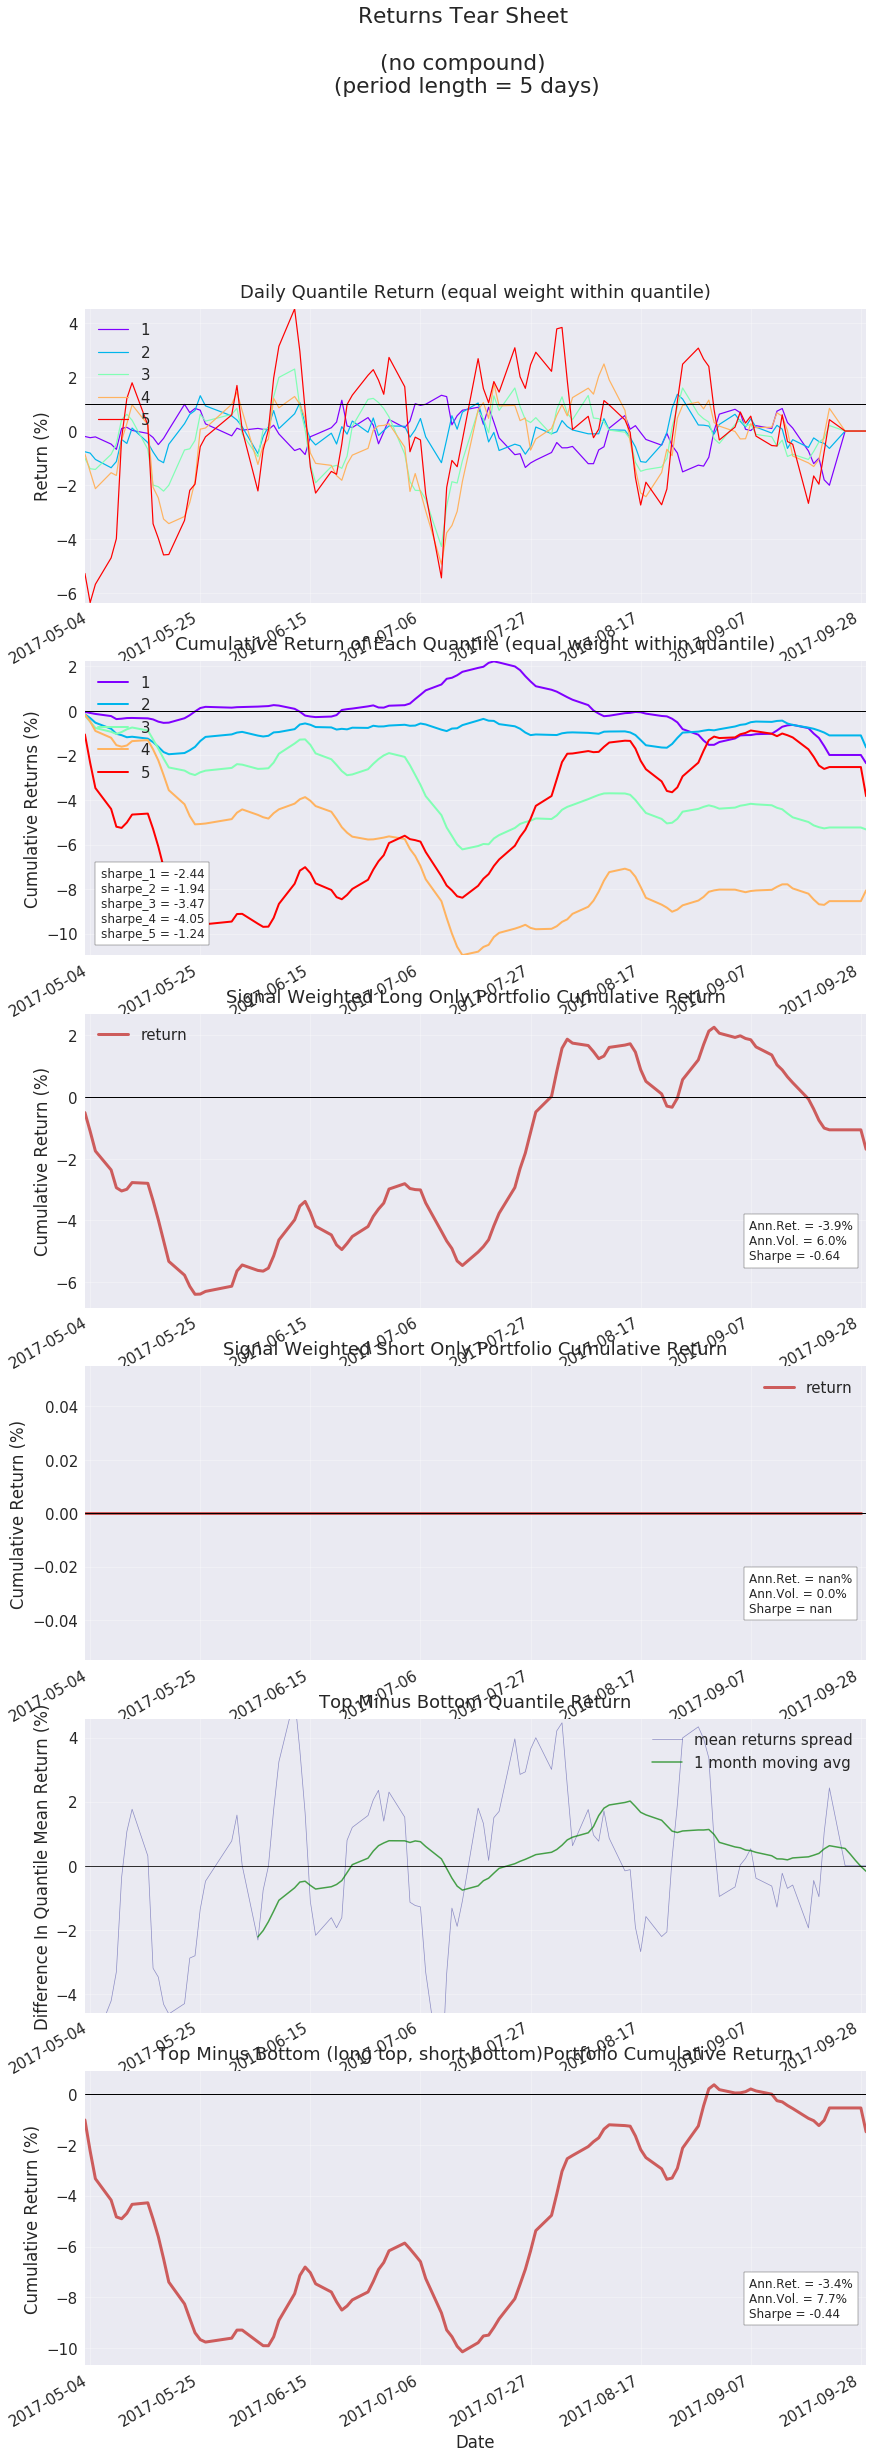

In [10]:
sd.create_returns_report()

## returns_report_data

- ` jaqs_fxdayu.research.signaldigger.digger.returns_report_data `

**简要描述：**

- 收益分析相关数据
- 需要执行create_returns_report后该属性才有值

**返回：**

由'period_wise_quantile_ret'，'cum_quantile_ret','cum_long_ret','cum_short_ret', 'period_wise_tmb_ret', 'cum_tmb_ret'所组成的字典(dict)
分别对应：各quantile每日收益,quantile累积收益,多头组合（按因子值大小加权做多因子值为正的）累积收益,空头组合（按因子值大小加权做空因子值为负的）累积收益，多空组合（等权做多quantile最大组、做空quantile最小组）每日收益、多空组合（等权做多quantile最大组、做空quantile最小组）累积收益

**示例：**

In [11]:
print(sd.returns_report_data.keys())
sd.returns_report_data['cum_quantile_ret'].head()

dict_keys(['period_wise_quantile_ret', 'cum_quantile_ret', 'cum_long_ret', 'cum_short_ret', 'period_wise_tmb_ret', 'cum_tmb_ret'])


,1,2,3,4,5
trade_date,,,,,
2017-05-03,-0.000403,-0.001536,-0.002002,-0.001690,-0.010550
2017-05-04,-0.000896,-0.003169,-0.004793,-0.004698,-0.023262
2017-05-05,-0.001330,-0.005273,-0.007637,-0.008967,-0.034614
2017-05-08,-0.002298,-0.007992,-0.009366,-0.012054,-0.044011
2017-05-09,-0.003656,-0.010253,-0.010315,-0.015345,-0.051984


## create_full_report

- ` jaqs_fxdayu.research.signaldigger.digger.create_full_report() `

**简要描述：**

- 收益分析+ic分析
- 需要执行process_signal_before_analysis后才能执行该方法

**返回：**

综合分析结果，并将结果保存至预设目录

**示例：**

In [ ]:
sd.create_full_report()